In [52]:
#required imports
import tensorflow as tf
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string 
import re
import nltk
import os

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [53]:
#mounting drive for dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
ls

drive/  model.png  sample_data/


In [55]:
#read json using pandas
df = pd.read_json("drive/MyDrive/Sarcasm_Headlines_Dataset.json",lines=True)

In [56]:
df

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0
...,...,...,...
26704,https://www.huffingtonpost.com/entry/american-...,american politics in moral free-fall,0
26705,https://www.huffingtonpost.com/entry/americas-...,america's best 20 hikes,0
26706,https://www.huffingtonpost.com/entry/reparatio...,reparations and obama,0
26707,https://www.huffingtonpost.com/entry/israeli-b...,israeli ban targeting boycott supporters raise...,0


In [57]:
#drop artucle link column
df.drop("article_link", inplace=True, axis=1)

In [58]:
df

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0
...,...,...
26704,american politics in moral free-fall,0
26705,america's best 20 hikes,0
26706,reparations and obama,0
26707,israeli ban targeting boycott supporters raise...,0


In [59]:
#preprocessing steps
def clean_text(text):

  text = text.lower() #converted to lowercase

  pattern = re.compile('https?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+') #removing link
  text = pattern.sub('', text) #replacing link with whitespace
  emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF"  # removing emoji, symbols, flags
                           u"\U0001F300-\U0001F5FF"  
                           u"\U0001F680-\U0001F6FF"  
                           u"\U0001F1E0-\U0001F1FF"  
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
  text = emoji.sub('',text)
  text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text) #additional special characters removed
  return text

In [60]:
def token_word(dframe):

  head_line = list() #new list
  lines = dframe['headline'].values.tolist() #df values to list

  for line in lines:
    line = clean_text(line) #passing each insatnce of corpus 
    tokenize = word_tokenize(line) #NLTK tokenize function
    pure_words = [word for word in tokenize if word.isalpha()] #keeping only alphabets
    stop_words = set(stopwords.words("english")) #loading 'English' stopwords
    filtered_words = [ word for word in pure_words if not word in stop_words] #removing all stopwords
    head_line.append(filtered_words) #added to the list

  return head_line

In [61]:
p_head_lines = token_word(df)
p_head_lines[:5]

[['former',
  'versace',
  'store',
  'clerk',
  'sues',
  'secret',
  'black',
  'code',
  'minority',
  'shoppers'],
 ['roseanne',
  'revival',
  'catches',
  'thorny',
  'political',
  'mood',
  'better',
  'worse'],
 ['mom',
  'starting',
  'fear',
  'sons',
  'web',
  'series',
  'closest',
  'thing',
  'grandchild'],
 ['boehner',
  'wants',
  'wife',
  'listen',
  'come',
  'alternative',
  'debtreduction',
  'ideas'],
 ['jk', 'rowling', 'wishes', 'snape', 'happy', 'birthday', 'magical', 'way']]

In [62]:
df.headline.apply(lambda x: len(x.split(" "))).describe()

count    26709.000000
mean         9.847842
std          3.172099
min          2.000000
25%          8.000000
50%         10.000000
75%         12.000000
max         39.000000
Name: headline, dtype: float64

In [16]:
EMBED_SIZE = 128
MAX_FEATURES = 27392
tokenizer = tf.keras.preprocessing.text.Tokenizer() #tokenizer object
tokenizer.fit_on_texts(p_head_lines) #creates the vocabulary index
list_tokenized_train = tokenizer.texts_to_sequences(p_head_lines) #texts to a sequence of integers
  
RNN_CELL_SIZE = 32
  
MAX_LEN = 10  # Since our mean length is 9.84
X_train = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_train, maxlen=MAX_LEN)#to make sure each input has same length
y_train = df['is_sarcastic']

In [17]:
word_index = tokenizer.word_index #to count words
print(f'Unique words ', len(word_index))

Unique words  27392


In [18]:
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        hidden_with_time_axis = tf.expand_dims(hidden, 1) #expand dims
        
        score = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis)) #primitive NN
        attention_weights = tf.nn.softmax(self.V(score), axis=1) #softmax along colimn
          
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1) #add column to reduce dims
        return context_vector, attention_weights

In [36]:
sequence_input = tf.keras.Input(shape=(MAX_LEN,), dtype="int32")
embedded_sequences = tf.keras.layers.Embedding(MAX_FEATURES + 1, EMBED_SIZE)(sequence_input)

In [43]:
# Getting our LSTM outputs
(lstm, forward_h, forward_c, backward_h, backward_c) = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(RNN_CELL_SIZE, return_sequences=True, return_state=True), name="bi_lstm_1")(embedded_sequences)

In [69]:
state_h = lstm = tf.keras.layers.Concatenate()([forward_h, backward_h])
context_vector, attention_weights = Attention(10)(lstm, state_h)
dense1 = lstm = tf.keras.layers.Dense(20, activation="relu")(context_vector)
dropout = lstm = tf.keras.layers.Dropout(0.3)(dense1)
output = lstm = tf.keras.layers.Dense(1, activation="sigmoid")(dropout)
  
model = tf.keras.Model(inputs=sequence_input, outputs=output)

In [70]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 10, 128)      3506304     ['input_2[0][0]']                
                                                                                                  
 bi_lstm_1 (Bidirectional)      [(None, 10, 64),     41216       ['embedding_1[0][0]']            
                                 (None, 32),                                                      
                                 (None, 32),                                                      
                                 (None, 32),                                                

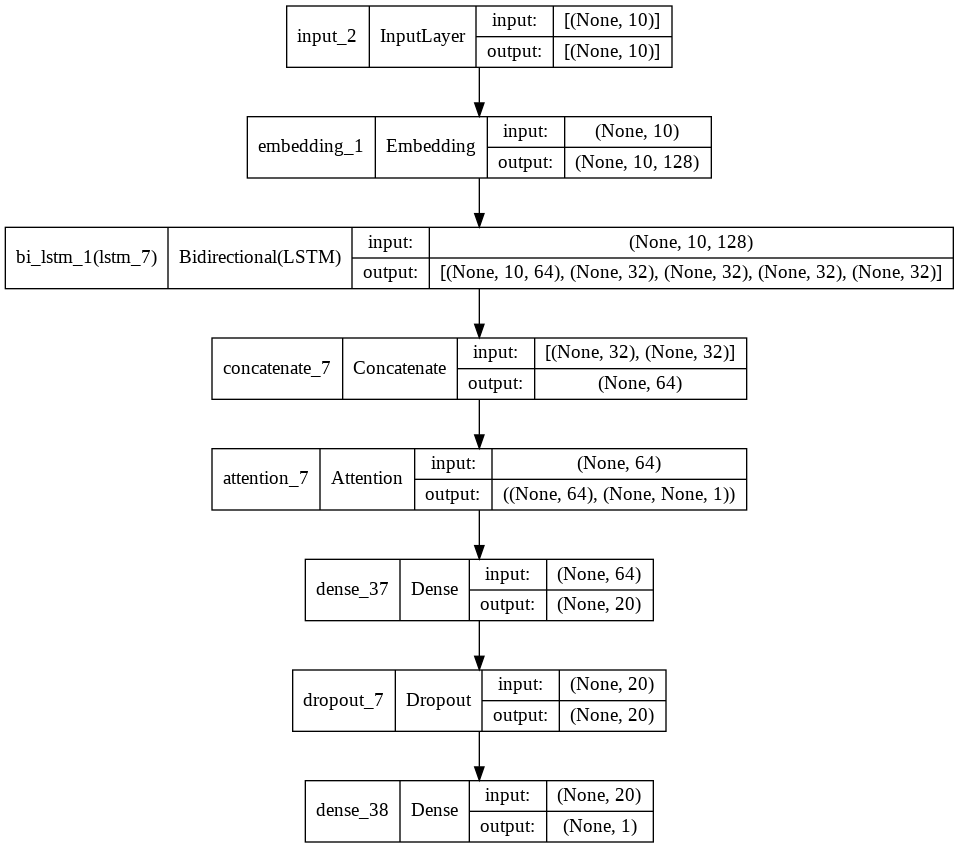

In [71]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [81]:
METRICS = [
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'),
]

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc',
                       METRICS])

In [82]:
BATCH_SIZE = 100
EPOCHS = 2
history = model.fit(X_train,y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.3)

Epoch 1/2
187/187 [==============================] - 23s 85ms/step - loss: 0.0231 - acc: 0.9926 - tp: 8148.0000 - fp: 39.0000 - tn: 10410.0000 - fn: 99.0000 - val_loss: 0.7924 - val_acc: 0.8490 - val_tp: 2803.0000 - val_fp: 536.0000 - val_tn: 4000.0000 - val_fn: 674.0000
Epoch 2/2
187/187 [==============================] - 14s 75ms/step - loss: 0.0172 - acc: 0.9948 - tp: 8184.0000 - fp: 35.0000 - tn: 10414.0000 - fn: 63.0000 - val_loss: 0.8888 - val_acc: 0.8454 - val_tp: 2672.0000 - val_fp: 434.0000 - val_tn: 4102.0000 - val_fn: 805.0000
